# FEATURE EXTRACTION NOTEBOOK

Feature extraction refers to the process of transforming raw data into features that can be processed while preserving the information in the original data set. It yields better results than applying machine learning directly to the raw data.

So far, we have done a bit of preprocessing using some image processing techniques. We have taken the open-cv libraries into account to apply such preprocessing. 
The resulting images have been archived into the dataset folder and transferred to google drive.

## PREPARATION
In the following, we are going to set some constants in order to use them later on. We also have mounting google drive in order to save the training logs into our g-drive.

### MOUNTING GOOGLE DRIVE
The first thing to do is to give google colab permission to access our drive so as to save the training checkpoints.

In [2]:
#MOUNTING GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True) 

# force_remount is an argument to force google drive to mount once again.

Mounted at /content/gdrive


### DOWNLOAD DATASET

Once we have finished our preprocessing, we have created a `dataset.zip` file from all the raw images. Now we download this file from our drive in order to start the training phase.

In [ ]:
# Download dataset from google drive
!gdown --id 1KhERp3hcRVwhaXSJx7w8xXLrCESmAp1w

# unzip the archive file
!unzip dataset.zip

# we don't need the archive file anymore
!rm dataset.zip

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 500
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
N_CLASSES = 31

In [ ]:
from tensorflow import keras

data_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=7, # rotation
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # brightness_range=(0.8, 1.2), # illumination
    # zoom_range=0.1, # zooming
    # horizontal_flip=False,
    # vertical_flip=False,
    # rescale=5,
    validation_split=0.1,
)

In [ ]:
import os

train_set = data_generator.flow_from_directory(
    os.path.join('/content', 'train_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    subset="training"
)

val_set = data_generator.flow_from_directory(
    os.path.join('/content', 'train_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    subset="validation"
)

Found 1116 images belonging to 31 classes.
Found 124 images belonging to 31 classes.


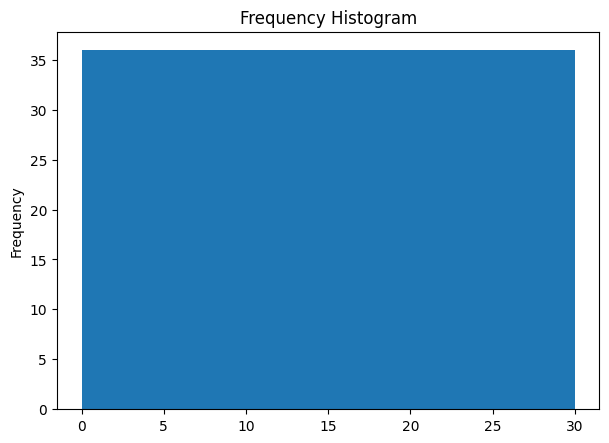

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(train_set.classes, bins=31)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

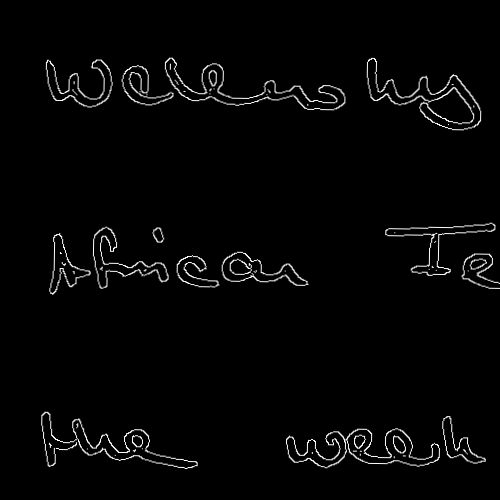

In [ ]:
from keras.preprocessing.image import array_to_img
def skl(dataset):
  for data in dataset:
    return data[0][0]
array_to_img(skl(train_set))

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [ ]:
# reduces learning rate if no improvement are seen
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1,
                                            verbose=0,
                                            factor=0.2,
                                            min_lr=0.000001)

# stop training if no improvements are seen
early_stop = EarlyStopping(monitor="val_loss",
                            mode="min",
                            patience=3,
                            restore_best_weights=True)

# saves model weights to file
checkpoint = ModelCheckpoint(os.path.join('/content/gdrive/MyDrive/biometric_project/model', 'cp-{epoch:04d}.h5'),
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True,
                            mode='min',
                            save_weights_only=True)


In [ ]:
from keras import models, layers

model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv2D(filters=32, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), kernel_size=(7,7),strides=(2,2), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling 
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(layers.BatchNormalization())

# 2nd Convolutional Layer
model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 3rd Convolutional Layer
model.add(layers.Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
# Batch Normalisation
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())

# 4th Convolutional Layer
model.add(layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
# Batch Normalisation
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())


# Passing it to a dense layer
model.add(layers.Flatten())
# 1st Dense Layer
model.add(layers.Dense(256, input_shape=(IMAGE_SIZE*IMAGE_SIZE*3,)))
model.add(layers.Activation('relu'))
# Add Dropout to prevent overfitting
model.add(layers.Dropout(0.4))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 2nd Dense Layer
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
# Add Dropout
model.add(layers.Dropout(0.4))
# Batch Normalisation
model.add(layers.BatchNormalization())


# Output Layer
model.add(layers.Dense(N_CLASSES))
model.add(layers.Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 247, 247, 32)      4736      
                                                                 
 activation (Activation)     (None, 247, 247, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    x=train_set,
    validation_data=val_set,
    epochs=150,
    validation_steps=len(val_set),
    steps_per_epoch=len(train_set),
    verbose=1,
    callbacks=[checkpoint, early_stop, learning_rate_reduction],
    )

Epoch 1/150
35/35 [==============================] - 84s 2s/step - loss: 4.0979 - accuracy: 0.0394 - val_loss: 8.7130 - val_accuracy: 0.0323 - lr: 0.0100
Epoch 2/150
35/35 [==============================] - 62s 2s/step - loss: 3.7799 - accuracy: 0.0681 - val_loss: 6.5134 - val_accuracy: 0.0484 - lr: 0.0100
Epoch 3/150
35/35 [==============================] - 60s 2s/step - loss: 3.4326 - accuracy: 0.1039 - val_loss: 5.2381 - val_accuracy: 0.0403 - lr: 0.0100
Epoch 4/150
35/35 [==============================] - 61s 2s/step - loss: 3.1218 - accuracy: 0.1371 - val_loss: 4.2259 - val_accuracy: 0.0887 - lr: 0.0100
Epoch 5/150
35/35 [==============================] - 60s 2s/step - loss: 2.8941 - accuracy: 0.1774 - val_loss: 2.9848 - val_accuracy: 0.1532 - lr: 0.0100
Epoch 6/150
35/35 [==============================] - 65s 2s/step - loss: 2.7628 - accuracy: 0.1935 - val_loss: 2.7257 - val_accuracy: 0.2339 - lr: 0.0100
Epoch 7/150
35/35 [==============================] - 61s 2s/step - loss: 2.5

In [ ]:
history = model.fit(
    x=train_set,
    validation_data=val_set,
    epochs=150,
    validation_steps=len(val_set),
    steps_per_epoch=len(train_set),
    verbose=1,
    callbacks=[checkpoint, early_stop, learning_rate_reduction],
    ) # 76

Epoch 1/150
93/93 [==============================] - 202s 2s/step - loss: 3.4450 - accuracy: 0.1979 - val_loss: 5.8160 - val_accuracy: 0.0345 - lr: 0.0100
Epoch 2/150
93/93 [==============================] - 193s 2s/step - loss: 2.7772 - accuracy: 0.3075 - val_loss: 2.6393 - val_accuracy: 0.3292 - lr: 0.0100
Epoch 3/150
93/93 [==============================] - 187s 2s/step - loss: 2.5467 - accuracy: 0.3283 - val_loss: 2.1448 - val_accuracy: 0.3918 - lr: 0.0100
Epoch 4/150
93/93 [==============================] - 187s 2s/step - loss: 2.2741 - accuracy: 0.3632 - val_loss: 1.7951 - val_accuracy: 0.4451 - lr: 0.0100
Epoch 5/150
93/93 [==============================] - 192s 2s/step - loss: 2.1004 - accuracy: 0.3918 - val_loss: 1.6411 - val_accuracy: 0.5110 - lr: 0.0100
Epoch 6/150
93/93 [==============================] - 189s 2s/step - loss: 1.9381 - accuracy: 0.4173 - val_loss: 1.5332 - val_accuracy: 0.5298 - lr: 0.0100
Epoch 7/150
93/93 [==============================] - 188s 2s/step - lo

In [ ]:
history = model.fit(
    x=train_set,
    validation_data=val_set,
    epochs=150,
    validation_steps=len(val_set),
    steps_per_epoch=len(train_set),
    verbose=1,
    callbacks=[checkpoint, early_stop, learning_rate_reduction],
    ) # 64

Epoch 1/150
35/35 [==============================] - 81s 2s/step - loss: 4.1007 - accuracy: 0.0439 - val_loss: 5.2021 - val_accuracy: 0.0242 - lr: 0.0100
Epoch 2/150
35/35 [==============================] - 78s 2s/step - loss: 3.8919 - accuracy: 0.0529 - val_loss: 4.6756 - val_accuracy: 0.0565 - lr: 0.0100
Epoch 3/150
35/35 [==============================] - 76s 2s/step - loss: 3.6343 - accuracy: 0.0762 - val_loss: 3.6476 - val_accuracy: 0.0806 - lr: 0.0100
Epoch 4/150
35/35 [==============================] - 76s 2s/step - loss: 3.3175 - accuracy: 0.1111 - val_loss: 3.2006 - val_accuracy: 0.1210 - lr: 0.0100
Epoch 5/150
35/35 [==============================] - 72s 2s/step - loss: 3.0726 - accuracy: 0.1398 - val_loss: 2.9500 - val_accuracy: 0.1532 - lr: 0.0100
Epoch 6/150
35/35 [==============================] - 75s 2s/step - loss: 2.9134 - accuracy: 0.1568 - val_loss: 2.7494 - val_accuracy: 0.2016 - lr: 0.0100
Epoch 7/150
35/35 [==============================] - 75s 2s/step - loss: 2.8

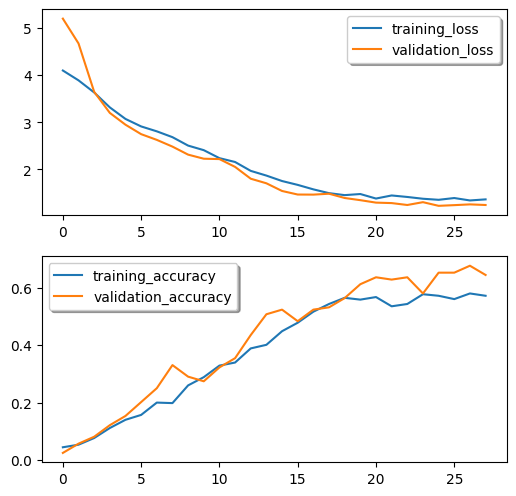

In [ ]:
import matplotlib.pyplot as plt

# plot training history
_, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="training_loss")
ax[0].plot(history.history['val_loss'], label="validation_loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="training_accuracy")
ax[1].plot(history.history['val_accuracy'], label="validation_accuracy")
ax[1].legend(loc='best', shadow=True)

plt.show()

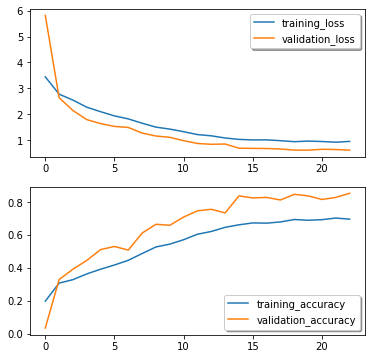

In [ ]:
import matplotlib.pyplot as plt

# plot training history
_, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="training_loss")
ax[0].plot(history.history['val_loss'], label="validation_loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="training_accuracy")
ax[1].plot(history.history['val_accuracy'], label="validation_accuracy")
ax[1].legend(loc='best', shadow=True)

plt.show()

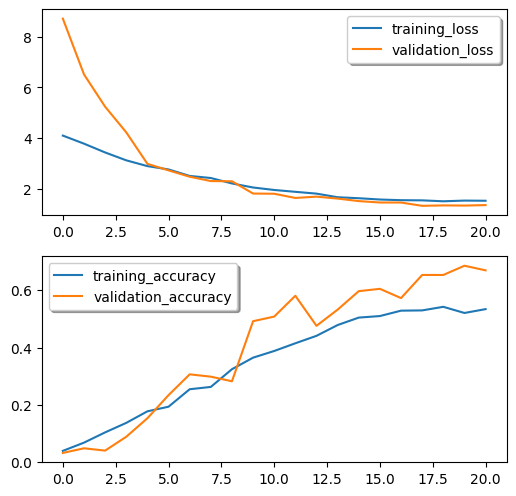

In [ ]:
import matplotlib.pyplot as plt

# plot training history
_, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="training_loss")
ax[0].plot(history.history['val_loss'], label="validation_loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="training_accuracy")
ax[1].plot(history.history['val_accuracy'], label="validation_accuracy")
ax[1].legend(loc='best', shadow=True)

plt.show()

In [ ]:
loss, acc = model.evaluate(val_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

4/4 [==============================] - 7s 1s/step - loss: 1.4072 - accuracy: 0.6290
Restored model, accuracy: 62.90%


In [ ]:
loss, acc = model.evaluate(val_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

4/4 [==============================] - 7s 2s/step - loss: 1.3126 - accuracy: 0.6371
Restored model, accuracy: 63.71%


In [ ]:
test_set = data_generator.flow_from_directory(
    os.path.join('/content', 'test_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
)

Found 372 images belonging to 31 classes.


In [ ]:
loss, acc = model.evaluate(test_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

12/12 [==============================] - 18s 1s/step - loss: 1.3178 - accuracy: 0.6317
Restored model, accuracy: 63.17%


In [ ]:
loss, acc = model.evaluate(test_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

16/16 [==============================] - 29s 2s/step - loss: 1.2074 - accuracy: 0.6572
Restored model, accuracy: 65.72%


In [ ]:
def apply_threshold(dic, threshold=0.05):
    
    for (key, value) in dic:
        if value >= threshold:
            print(f'author id: {key} ----------> score: {str(value*100)}%')

In [ ]:
import numpy as np
from keras.preprocessing import image
classes = val_set.class_indices
def test_on_a_image(path):
  test_image = image.load_img(path, target_size = (IMAGE_SIZE, IMAGE_SIZE))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image)
  dic = {}
  for (key, value) in classes.items():
      dic[key] = float(format(result[0][value],'.5f'))

  return apply_threshold(sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10])

In [ ]:
model.get_layer(index=20).output

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'batch_normalization_10')>

In [ ]:
feature_extractor = keras.Model(
    inputs=model.input,
    outputs=model.get_layer(index=20).output
)

feature_extractor.compile(optimizer=keras.optimizers.Adam(0.02),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 500, 500, 3)]    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 247, 247, 32)      4736      
                                                                 
 activation_7 (Activation)   (None, 247, 247, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 123, 123, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        51264 

## Load two different model


In [ ]:
model.load_weights('/content/gdrive/MyDrive/biometric_project/model_with_53_accuracy_with_balanced/cp-0021.h5')

In [ ]:
loss, acc = model.evaluate(test_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

16/16 [==============================] - 34s 2s/step - loss: 1.6330 - accuracy: 0.5375
Restored model, accuracy: 53.75%


In [ ]:
model.load_weights('/content/gdrive/MyDrive/biometric_project/model_with_76_accuracy_with_not_balanced/cp-0020.h5')

In [ ]:
loss, acc = model.evaluate(test_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

16/16 [==============================] - 33s 2s/step - loss: 0.8192 - accuracy: 0.7688
Restored model, accuracy: 76.88%


In [ ]:
model.load_weights('/content/gdrive/MyDrive/biometric_project/model_with_64_accuracy_with_balanced/cp-0021.h5')

In [ ]:
loss, acc = model.evaluate(test_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

16/16 [==============================] - 30s 2s/step - loss: 1.2484 - accuracy: 0.6430
Restored model, accuracy: 64.30%
